# Experiment Tracking

In [24]:
import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import root_mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

import mlflow

import pickle

In [15]:
pd.options.mode.chained_assignment = None  # default='warn'

## Data Preprocessing

In [16]:
def import_data(url):
  return pd.read_parquet(url)

In [17]:
def process_data(df):
  df['duration'] = (df.lpep_dropoff_datetime - df.lpep_pickup_datetime).apply(lambda x: x.total_seconds() / 60)
  df = df.loc[(df.duration >= 1) & (df.duration <= 60), :]

  return df

In [18]:
def prepare_features(df, dv=None):
  categorical_variables = ['PULocationID', 'DOLocationID']
  numerical_variables = ['trip_distance']

  df[categorical_variables] = df[categorical_variables].astype(str)
  df['PU_DO'] = df['PULocationID'] + '_' + df['DOLocationID']

  # input_variables = ['PU_DO', 'trip_distance']
  input_variables = ['PULocationID', 'DOLocationID']

  df_dicts = df[input_variables].to_dict(orient="records")

  if dv:
    X = dv.transform(df_dicts)
  else:
    dv = DictVectorizer()
    X = dv.fit_transform(df_dicts)
  
  y = df.duration.values

  return X, y, dv

In [19]:
def compute_error(X, y, model):
  preds = model.predict(X)
  return root_mean_squared_error(preds, y)

In [27]:
def plot_distribution(df, vars):
  for var in vars:
    sns.kdeplot(data=df, x=var, fill=True)

In [20]:
url_train = "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet"
url_val = "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet"

df_train = import_data(url_train)
df_val = import_data(url_val)

df_train = process_data(df_train)
df_val = process_data(df_val)

X_train, y_train, dv = prepare_features(df_train)
X_val, y_val, _ = prepare_features(df_val, dv)

(76518, 20)
506


## Manual Logging

In [21]:
TRACKING_URI = "sqlite:///mlflow.db"
EXPERIMENT_NAME = "nyc-taxi-experiment"

In [22]:
# mlflow ui --backend-store-uri sqlite:///mlflow.db
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1722064660936, experiment_id='1', last_update_time=1722064660936, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

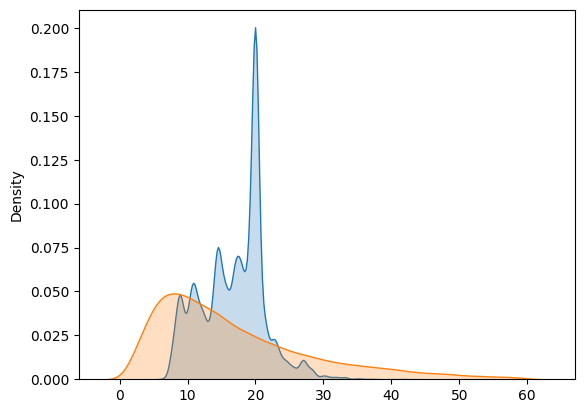

In [33]:
alpha = .01
model = Lasso(alpha)
model.fit(X=X_train, y=y_train)
rmse = compute_error(X=X_val, y=y_val, model=model)

preds = model.predict(X=X_train)
sns.kdeplot(preds, fill=True)
sns.kdeplot(data=y_train, fill=True)

with mlflow.start_run():
  mlflow.set_tag("developer", "Bastien Winant")

  mlflow.log_params({
    "train_data": url_train,
    "val_data": url_val,
    "alpha": alpha
  })

  mlflow.log_metric("rmse", rmse)